# Setup

## Imports

In [ ]:
import os
import glob

from PIL import Image

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pylibdmtx.pylibdmtx import decode
from ultralytics import YOLO, settings
root_dir = os.getcwd().replace('\\notebooks', '')
settings.update({'datasets_dir': f'{root_dir}/data/processed/test', 'runs_dir': f'{root_dir}/yolo/runs'})

import torch
from torchvision.transforms import v2, InterpolationMode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from unet import binarizer

## Loading Models

In [2]:
# step 1
yolo = YOLO('../../yolo/models/ultralytics_finetuned.pt')

In [3]:
# step 2
def load_binarizer(statedict_path):
    model = binarizer(in_channels=3, out_channels=1).to(device)
    model.load_state_dict(torch.load(statedict_path))
    model.eval()
    return model

# loading all binarizer weights for later comparison
binarizer_100 = load_binarizer('../../torch/binarizer_100.pt')
binarizer_101 = load_binarizer('../../torch/binarizer_101.pt')
binarizer_102 = load_binarizer('../../torch/binarizer_102.pt')

## Preparing Images for Binarizer


0: 640x640 1 Data Matrix, 7.0ms
Speed: 4.0ms preprocess, 7.0ms inference, 59.1ms postprocess per image at shape (1, 3, 640, 640)


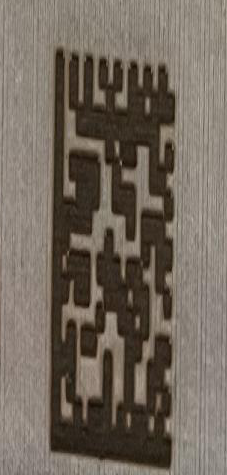

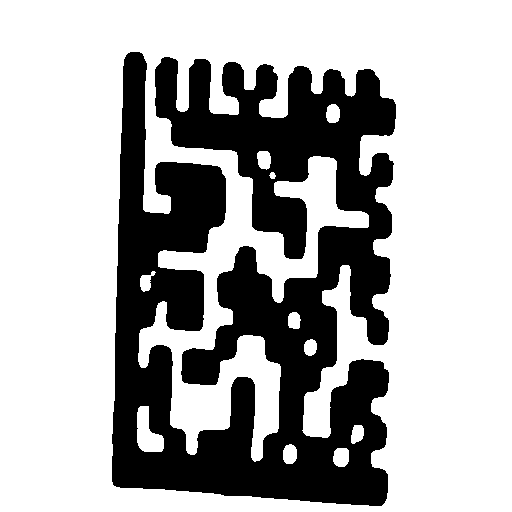

In [4]:
def prepare_image(PIL_img):
    transform = v2.Compose([
        v2.Resize((512, 512), InterpolationMode.BILINEAR),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    img = transform(PIL_img).unsqueeze(0).to(device)

    # img = v2.to_tensor(PIL_img).unsqueeze(0).to(device)
    # img = v2.resize(img, (512, 512), InterpolationMode.BILINEAR)
    return img

# testing
img = Image.open('../../data/MAN/images/test/1G9V68937920005_jpeg.rf.8cf4ab8c3c91d302bcc6d81776399c39.jpg')
yolo_result = yolo(img)
box = yolo_result[0].boxes.xyxy.tolist()[0]

# crop with some padding (to not have too small of a crop)
pad = 45
img_crop = img.crop((max(0, box[0]-pad), max(0, box[1]-pad), max(0, box[2]+pad), max(0, box[3]+pad)))
display(img_crop)

# binarize
img_bin = binarizer_100(prepare_image(img_crop))

# binarize with threshold
img_bin = (img_bin > 0.5).float()

# transform to PIL
img_bin = v2.ToPILImage()(img_bin.squeeze(0).cpu().detach())

# display
display(img_bin)

## Full Evaluation Pipeline

In [5]:
def check_decoding_validity(img_path, decoded_string):

    actual_decoding = os.path.basename(img_path).split('_')[0]
    actual_decoding = actual_decoding.replace('-', '') # minor cleaning

    # fixing some actual decodings
    if actual_decoding == 'KV8INMEP':
        actual_decoding = '#D1FPE50HA9NS0047XG264##KV8INMEP'
    elif actual_decoding == 'KW8PXY3D':
        actual_decoding = '#D1FPE50HA9NS0047XG264##KW8PXY3D'

    if decoded_string == actual_decoding:
        return True
    else:
        print(f'Invalid decoding! Expected: {actual_decoding}, got: {decoded_string}')
        print(f'Image path: {img_path}')
        return False

In [6]:
def evaluation_pipeline(yolo, binarizer, imgs_path):
    # get all images
    imgs = glob.glob(f'{imgs_path}/*.jpg')

    results = {'img_path': [], 'decoded': [], 'cropped_img': [], 'binarized_img': []}
    valid_decoding_count = 0
    for img_path in imgs:
        img = Image.open(img_path)

        yolo_result = yolo(img, verbose=False)

        try:
            box = yolo_result[0].boxes.xyxy.tolist()[0]
        except:
            results['img_path'].append(img_path)
            results['decoded'].append(None)
            results['cropped_img'].append(None)
            results['binarized_img'].append(None)
            # print progress
            print(f'{len(results["img_path"])} / {len(imgs)}', end='\r')
            continue

        # crop with some padding (to not have too small of a crop)
        pad = 45
        img_crop = img.crop((max(0, box[0]-pad), max(0, box[1]-pad), max(0, box[2]+pad), max(0, box[3]+pad)))

        # binarize with model (gives sigmoid range)
        img_bin = binarizer(prepare_image(img_crop))

        # binarize with threshold (force to 0 or 1)
        img_bin = (img_bin > 0.5).float()

        # transform to PIL for visialization & decoding
        PIL_img = v2.ToPILImage()(img_bin.squeeze(0).cpu().detach())

        # decode
        decoded = decode(PIL_img, timeout=1000, max_count=1)
        if len(decoded) == 0:
            decoded = None
        else:
            decoded = decoded[0].data.decode('utf-8')

        results['img_path'].append(img_path)
        results['decoded'].append(decoded)
        results['cropped_img'].append(img_crop.resize((512, 512)))
        results['binarized_img'].append(PIL_img)

        # check decoding validity (if decoded)
        if decoded and check_decoding_validity(img_path, decoded):
            valid_decoding_count += 1

        # print progress
        print(f'{len(results["img_path"])} / {len(imgs)}', end='\r')

    print(f'Valid decoding count: {valid_decoding_count} / {len(imgs)}')
    return pd.DataFrame(results)

# Running Pipeline

In [7]:
results_100 = evaluation_pipeline(yolo, binarizer_100, '../../data/MAN/images/test')

Valid decoding count: 9 / 50


In [8]:
results_101 = evaluation_pipeline(yolo, binarizer_101, '../../data/MAN/images/test')

Valid decoding count: 0 / 50


In [9]:
results_102 = evaluation_pipeline(yolo, binarizer_102, '../../data/MAN/images/test')

Valid decoding count: 8 / 50


# Displaying Decoded Results

In [10]:
def display_results(results):
    results_valid = results[results['decoded'].notnull()]
    for _, row in results_valid.iterrows():
        img_crop = row['cropped_img']
        img_bin = row['binarized_img']
        filepath = row['img_path']
        print(f'Filepath: {filepath}')
        print(f'Decoded: {row["decoded"]}')
        display(img_crop)
        display(img_bin)

Filepath: ../../data/MAN/images/test\1G9V68937920005_jpeg.rf.8cf4ab8c3c91d302bcc6d81776399c39.jpg
Decoded: 1G9V68937920005


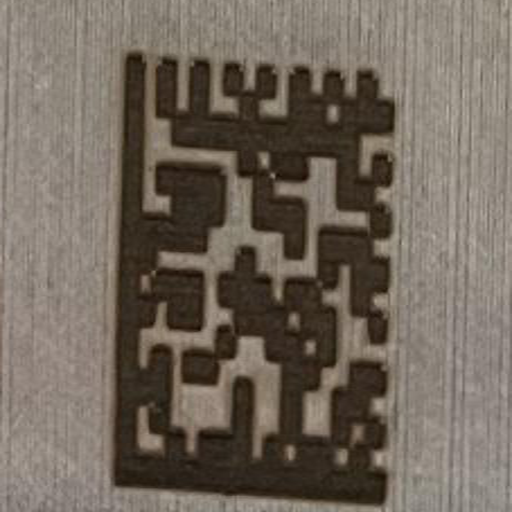

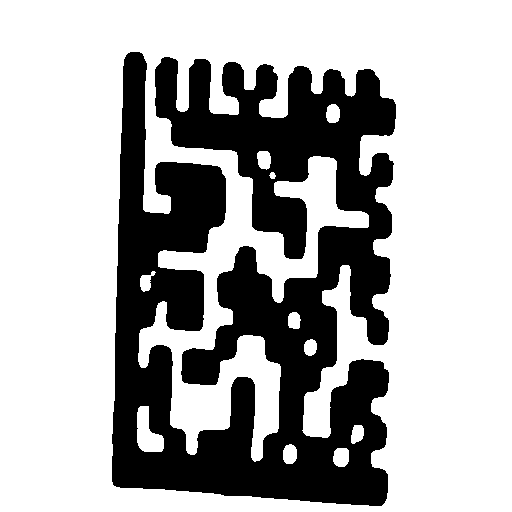

Filepath: ../../data/MAN/images/test\2501151902100-09_png.rf.6f5c5fd6b19124245921e0c5a508600b.jpg
Decoded: 250115190210009


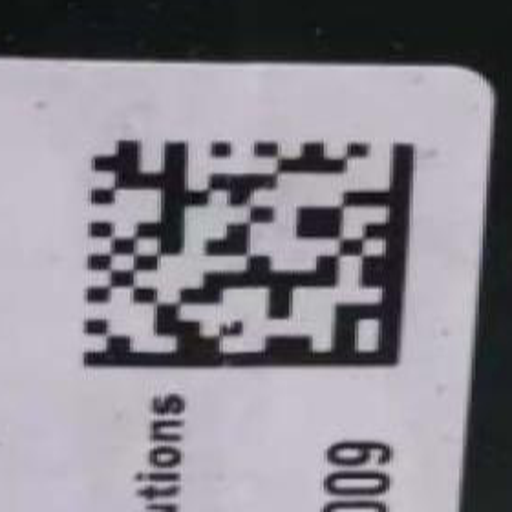

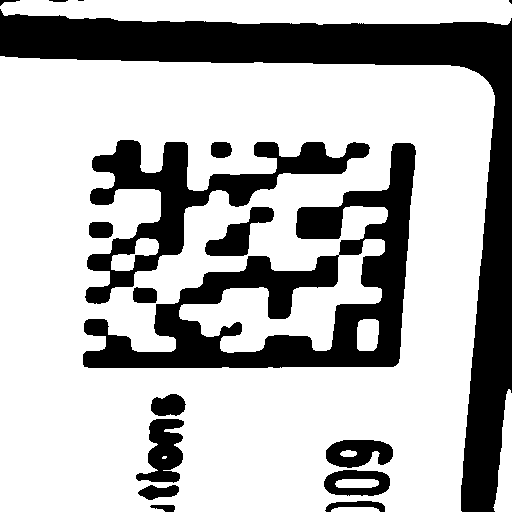

Filepath: ../../data/MAN/images/test\2501151902100-16_png.rf.85ac3bd58894a111e28ee29675482a32.jpg
Decoded: 250115190210016


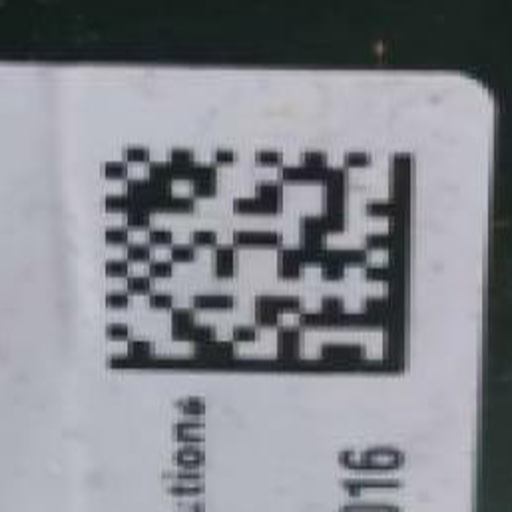

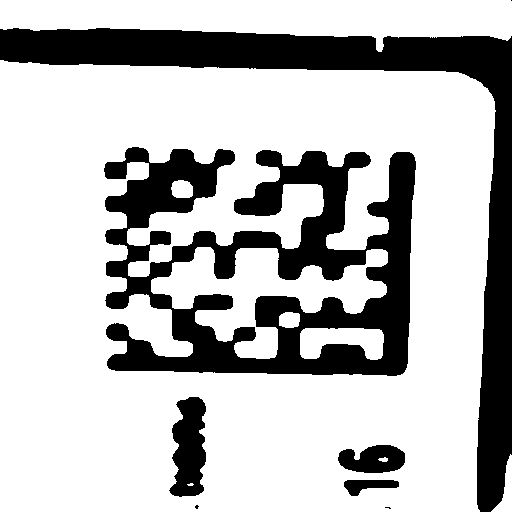

Filepath: ../../data/MAN/images/test\2501152055300-06_png.rf.4a7172c0b27de1c40e1902ade233181f.jpg
Decoded: 250115205530006


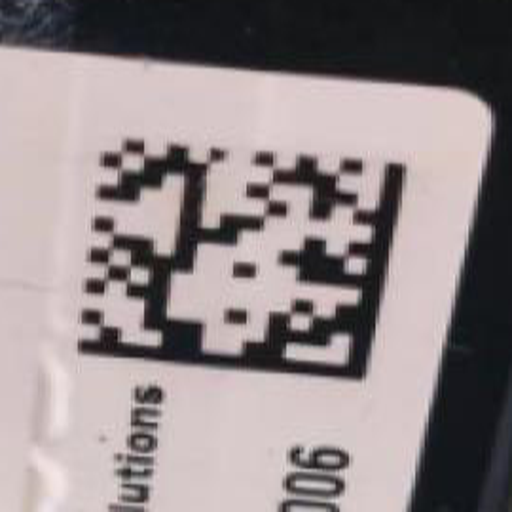

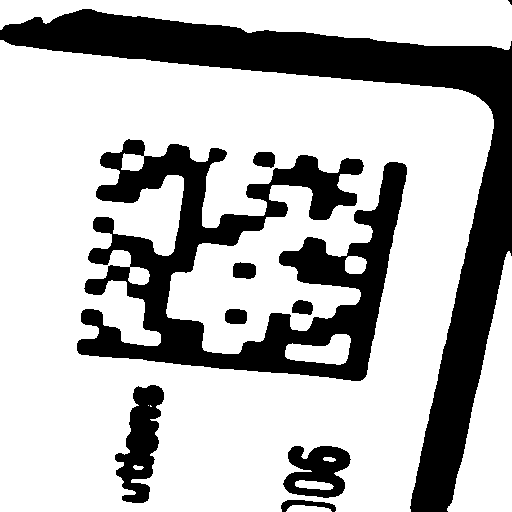

Filepath: ../../data/MAN/images/test\2501152055300-14_png.rf.6c6586f4ff83ed7a388088eba73d1e89.jpg
Decoded: 250115205530014


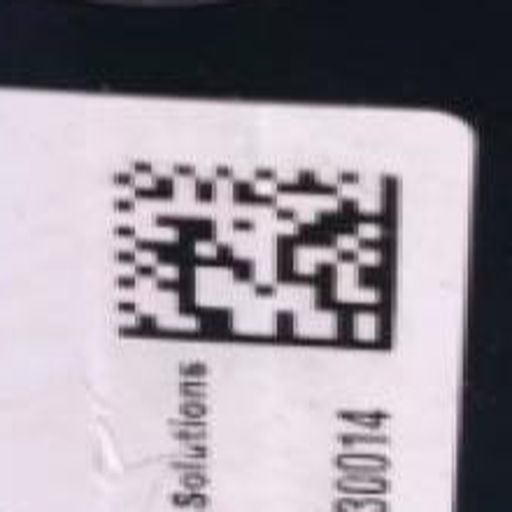

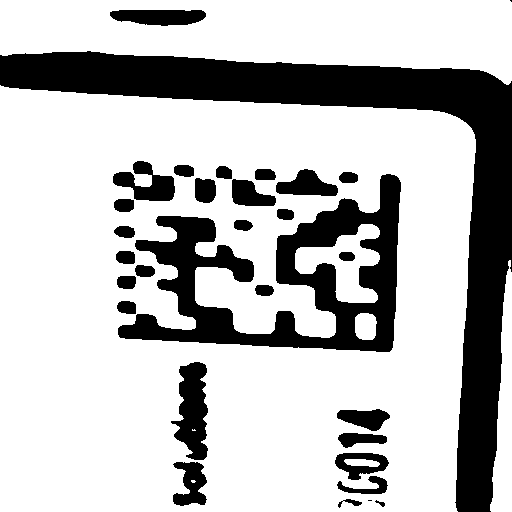

Filepath: ../../data/MAN/images/test\4E0Z15828730001_jpeg.rf.d593c4fcfa568963ad2edbc5d442f95d.jpg
Decoded: 4E0Z15828730001


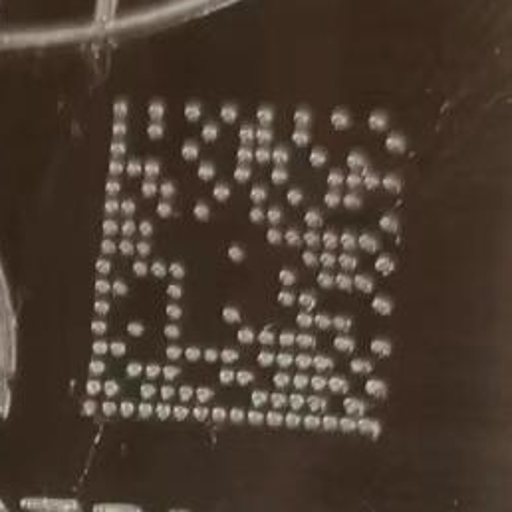

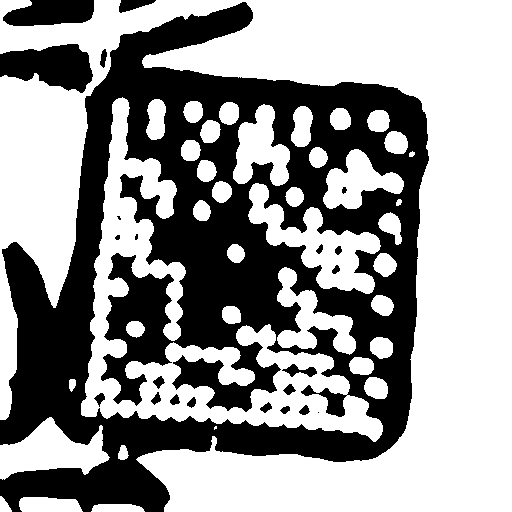

Filepath: ../../data/MAN/images/test\4F1K99136940006_png.rf.f08cc912e89714f81017019c468f26d0.jpg
Decoded: 4F1K99136940006


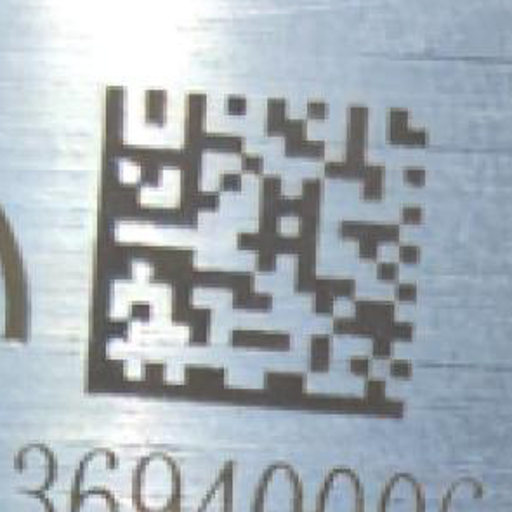

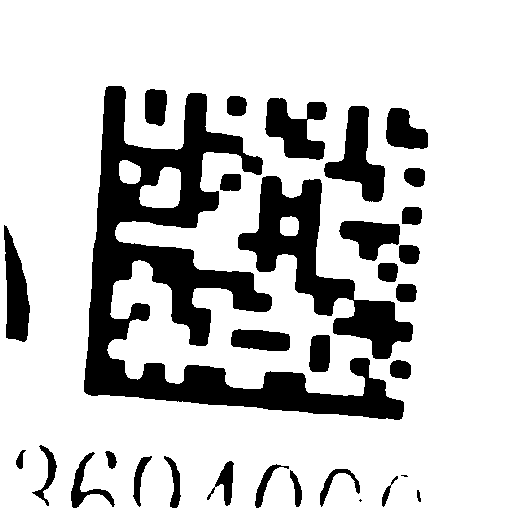

Filepath: ../../data/MAN/images/test\KV8INMEP_jpeg.rf.619f9e10ae682f8dcd1ba3d740ea708e.jpg
Decoded: #D1FPE50HA9NS0047XG264##KV8INMEP


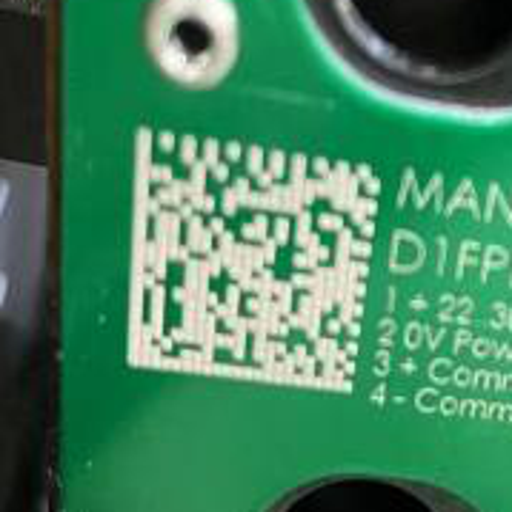

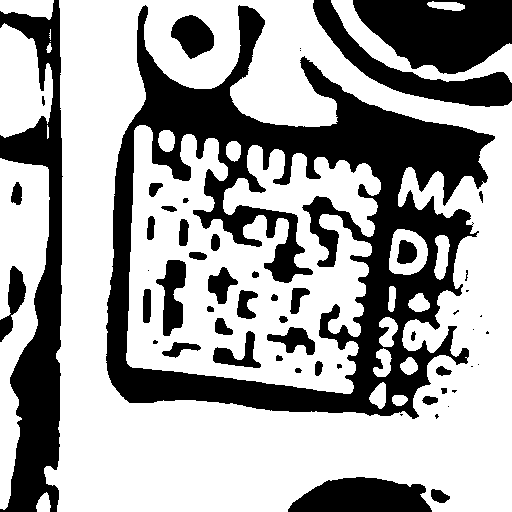

Filepath: ../../data/MAN/images/test\KW8PXY3D_png.rf.9d30dbc7c2120e2e22903e3720a708d3.jpg
Decoded: #D1FPE50HA9NS0047XG264##KW8PXY3D


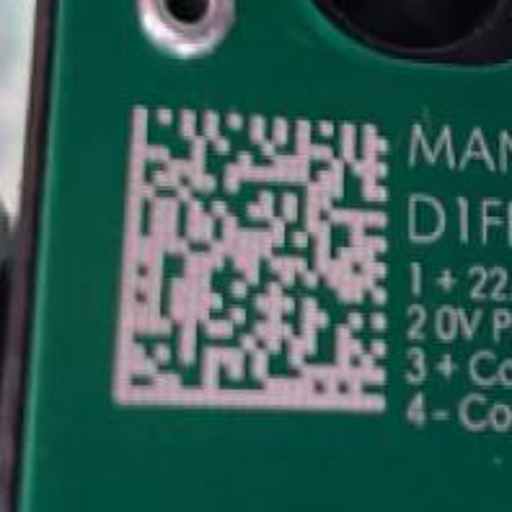

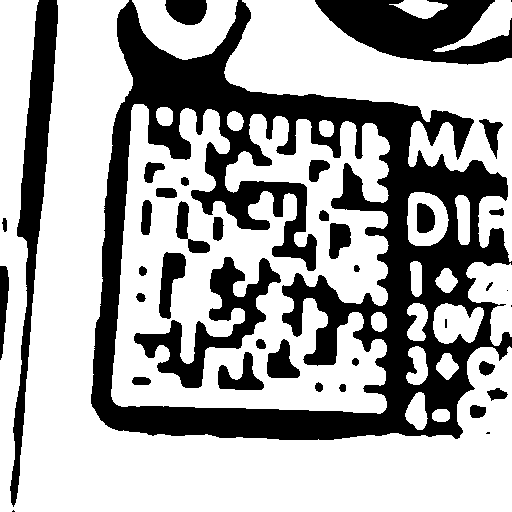

In [11]:
display_results(results_100)

In [12]:
display_results(results_101)

Filepath: ../../data/MAN/images/test\2501151902100-09_png.rf.6f5c5fd6b19124245921e0c5a508600b.jpg
Decoded: 250115190210009


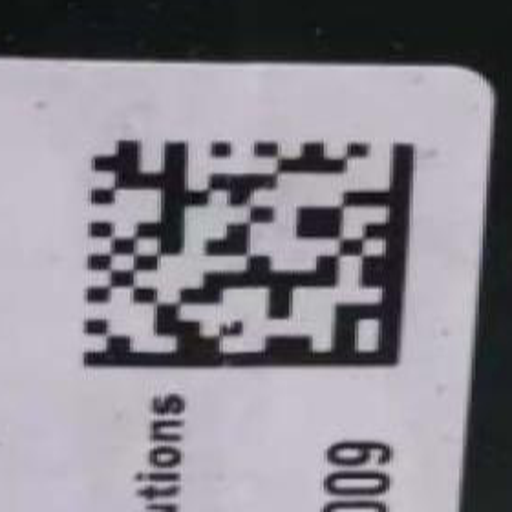

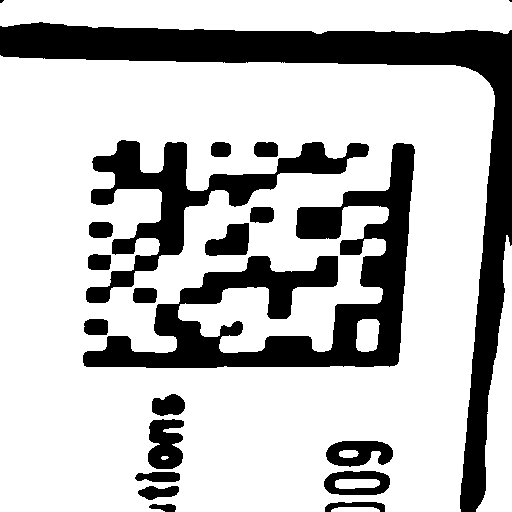

Filepath: ../../data/MAN/images/test\2501151902100-16_png.rf.85ac3bd58894a111e28ee29675482a32.jpg
Decoded: 250115190210016


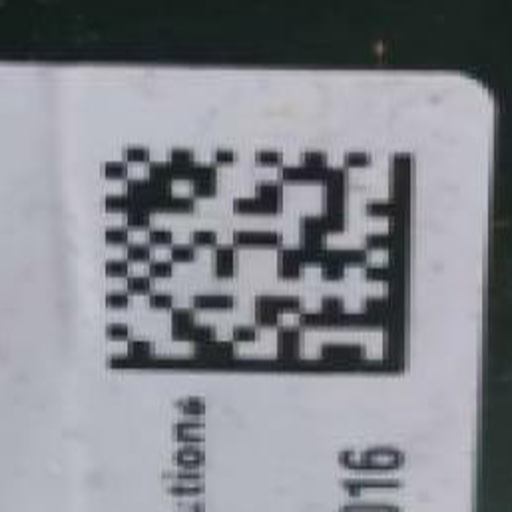

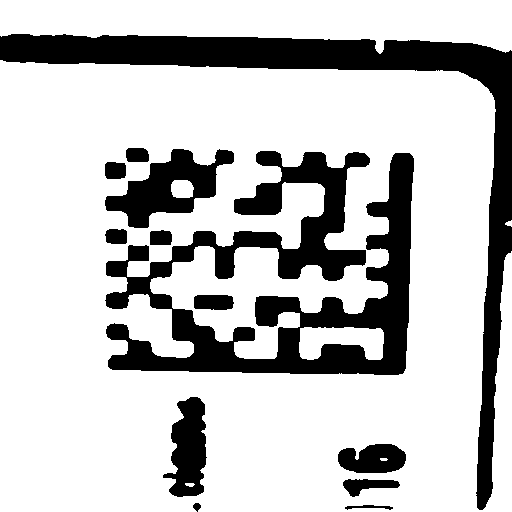

Filepath: ../../data/MAN/images/test\2501152055300-06_png.rf.4a7172c0b27de1c40e1902ade233181f.jpg
Decoded: 250115205530006


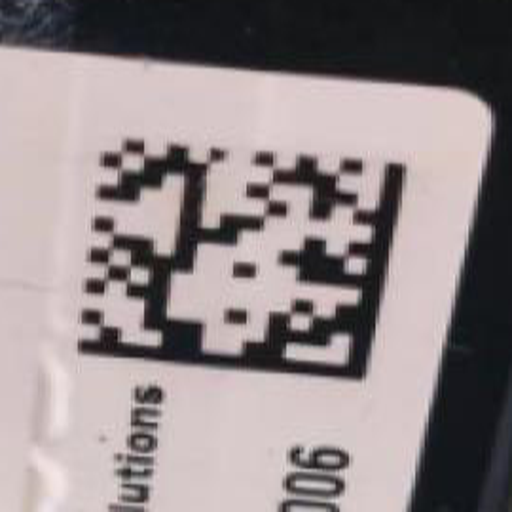

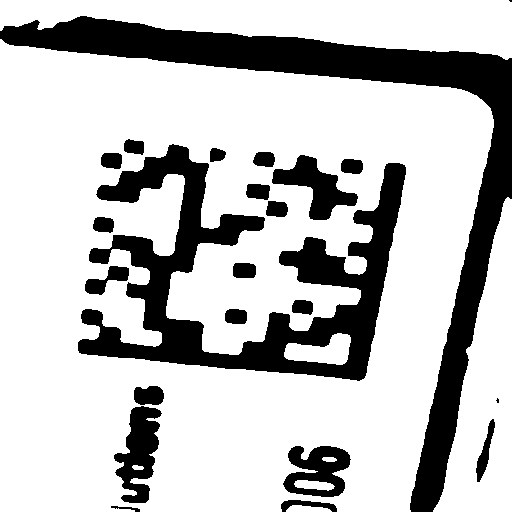

Filepath: ../../data/MAN/images/test\2501152055300-14_png.rf.6c6586f4ff83ed7a388088eba73d1e89.jpg
Decoded: 250115205530014


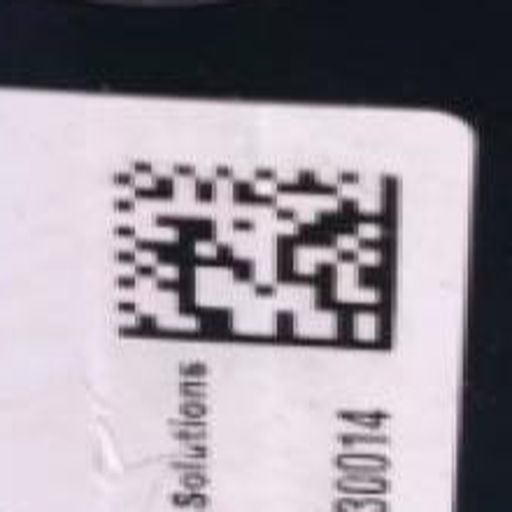

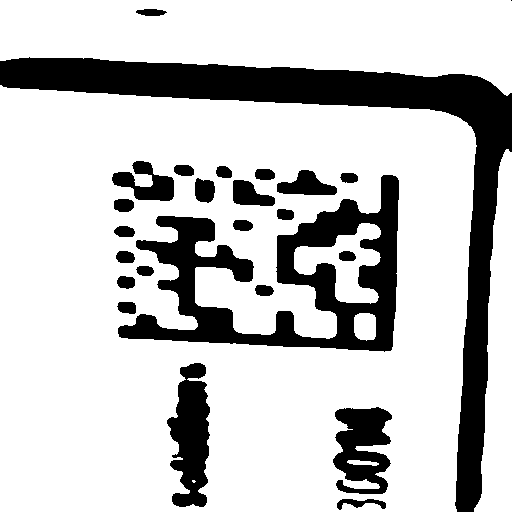

Filepath: ../../data/MAN/images/test\4F1K99136940006_png.rf.f08cc912e89714f81017019c468f26d0.jpg
Decoded: 4F1K99136940006


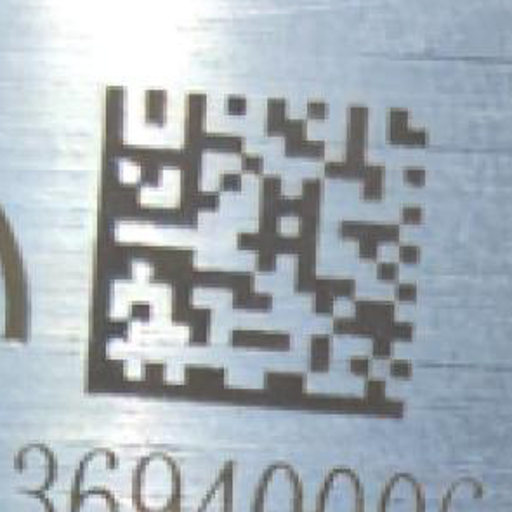

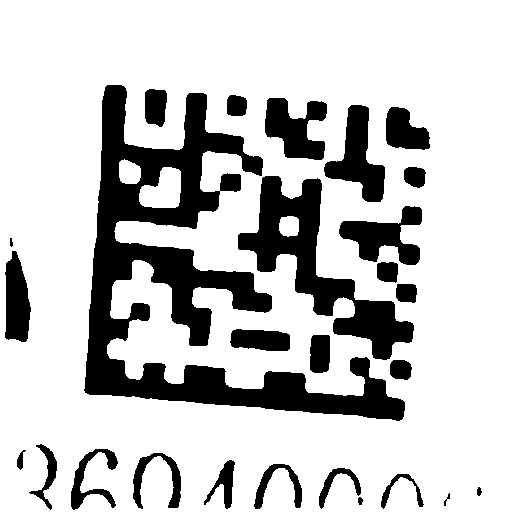

Filepath: ../../data/MAN/images/test\4F1K99136940007_png.rf.1f1b5e72a0fa3b582e32eaacac8c5d54.jpg
Decoded: 4F1K99136940007


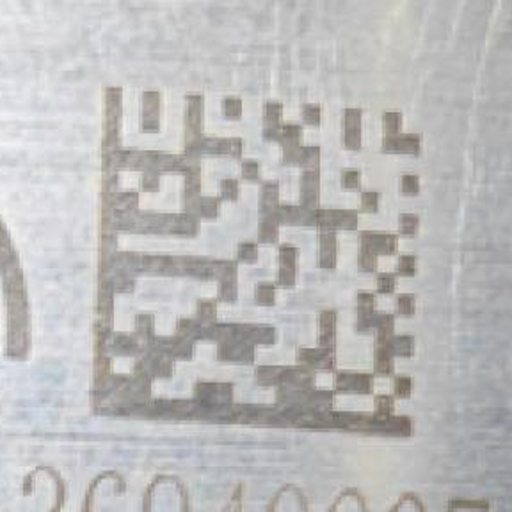

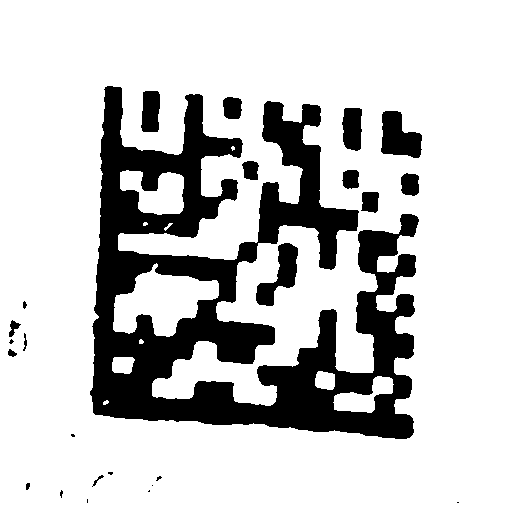

Filepath: ../../data/MAN/images/test\KV8INMEP_jpeg.rf.619f9e10ae682f8dcd1ba3d740ea708e.jpg
Decoded: #D1FPE50HA9NS0047XG264##KV8INMEP


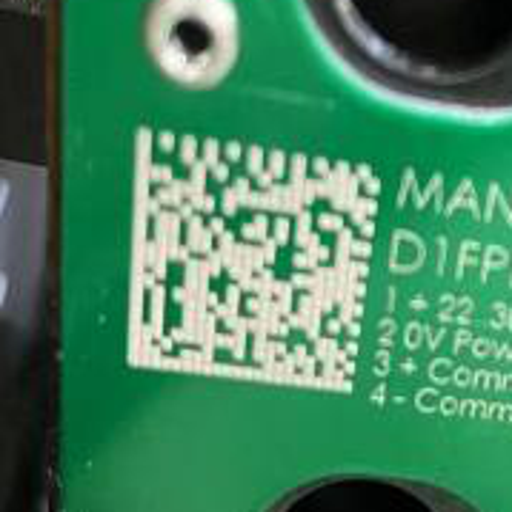

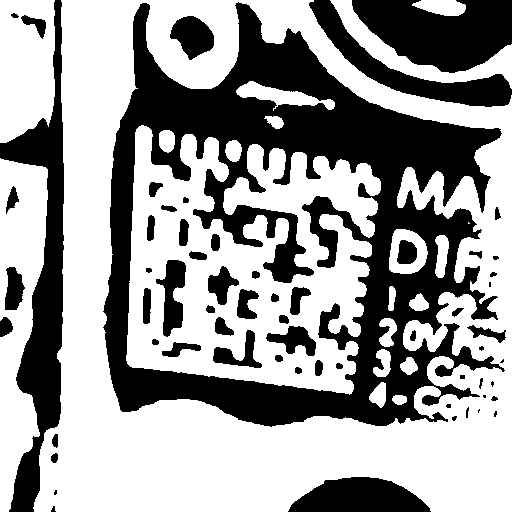

Filepath: ../../data/MAN/images/test\KW8PXY3D_png.rf.9d30dbc7c2120e2e22903e3720a708d3.jpg
Decoded: #D1FPE50HA9NS0047XG264##KW8PXY3D


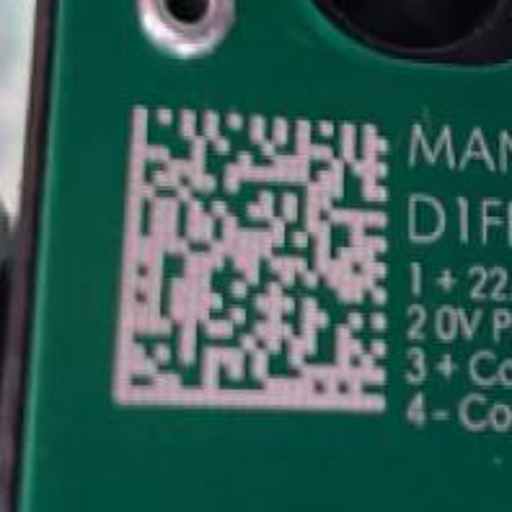

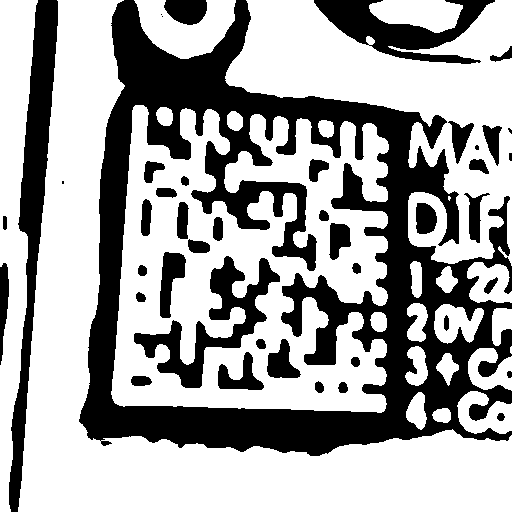

In [13]:
display_results(results_102)